In [1]:
using Pkg
Pkg.activate(joinpath(pwd(),".."))
using Particles
using Plots
using NetCDF
using DataFrames
using Dates
using CSV

Activating environment at `~/deltares/src/julia/Particles/Project.toml`


┌ Info: Recompiling stale cache file /home/verlaanm/.julia/compiled/v1.2/Particles/JbsmE.ji for Particles [9b8f9cb0-d3d2-11e9-0098-050335538f81]
└ @ Base loading.jl:1240


In [2]:
# read track data
t=[]
push!(t,CSV.read("East_Bound_combined_229068000.csv",header=2))
push!(t,CSV.read("East_Bound_combined_241463000.csv",header=2))
push!(t,CSV.read("East_Bound_combined_249420000.csv",header=2))
push!(t,CSV.read("East_Bound_combined_256735000.csv",header=2))
push!(t,CSV.read("East_Bound_combined_25903000.csv",header=2))
# convert times from strings to DateTime values
for ti=1:length(t)
   times=t[ti][:,1]
   ts=[DateTime(t,"dd/mm/yyyy HH:MM:SS") for t=times]
   t[ti].Times=ts
end
#get names of the ships
shipnames=[]
for si=1:5
   push!(shipnames,t[si].Name[20])
end


In [3]:
# read GTSM current data
dflow_map=load_nc_info(".",r"gtsm_fine_...._map.nc")
t0=get_reftime(dflow_map)
# create interpolation functions u1(x,y,z,t) and v1(x,y,z,t) with t in seconds relative to t0
interp=load_dflow_grid(dflow_map,50,false)
u1,v1=initialize_interpolation(dflow_map,interp,t0)
# some tests
#ind=find_index(interp,-2.0,50.0)
#ff=u1(-2.0,50.0,0.0,0.) #lon,lat,dummy,t with t in seconds relative to t0
# create timeseries at one point
lon=-2.0
lat=50.0
ts=(14.0*24.0*3600.0):1800.0:(18.0*24.0*3600.0) #times in seconds since t0
tt=t0+ts.*Second(1) #convert to DateTime
uu=zeros(length(tt))
vv=zeros(length(tt))
for ti=1:length(tt)
  uu[ti]=u1(lon,lat,0.0,ts[ti])
  vv[ti]=v1(lon,lat,0.0,ts[ti])
end


compute index:
- /home/verlaanm/deltares/src/julia/Particles/case_ais_channel/gtsm_fine_0002_map.nc
initialize caching for /home/verlaanm/deltares/src/julia/Particles/case_ais_channel/gtsm_fine_0002_map.nc ...


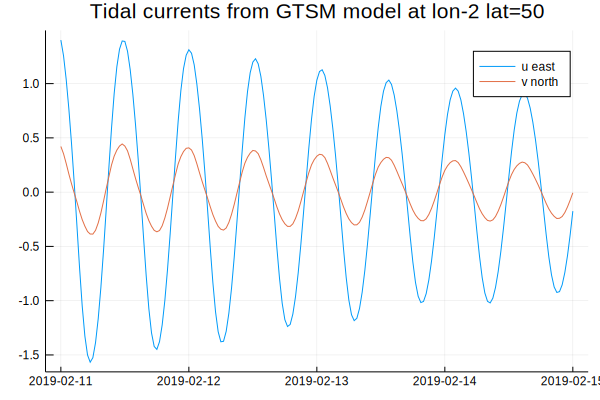

In [4]:
plot(tt,[uu,vv],label=["u east","v north"])
title!("Tidal currents from GTSM model at lon-2 lat=50")

In [5]:
# first interpolate to track positions and times for track 1
utrack1=zeros(length(t[1].Times))
vtrack1=zeros(length(t[1].Times))
ttrack1=zeros(length(t[1].Times))
for ti=1:length(ttrack1)
   time=(t[1].Times[ti]-t0).value/1000 #convert to seconds relative to t0
   #println("time=$(time) $(ti)")
   ttrack1[ti]=time
   utrack1[ti]=u1(t[1].Lon[ti],t[1].Lat[ti],0.0,ttrack1[ti])
   vtrack1[ti]=v1(t[1].Lon[ti],t[1].Lat[ti],0.0,ttrack1[ti])
end


https://www.gebco.net/data_and_products/gebco_web_services/web_map_service/mapserv?height=1000&styles=default&format=image%2Fpng&SERVICE=WMS&VERSION=1.1.1&width=1000&REQUEST=GetMap&layers=GEBCO_LATEST&SRS=epsg%3A4326&bbox=-5.5%2C48.5%2C1.5%2C51.5
Cache folder .cache already exists
Cache file .cache/www.gebco.net_16412945355490550872.png already exists. Using cached file


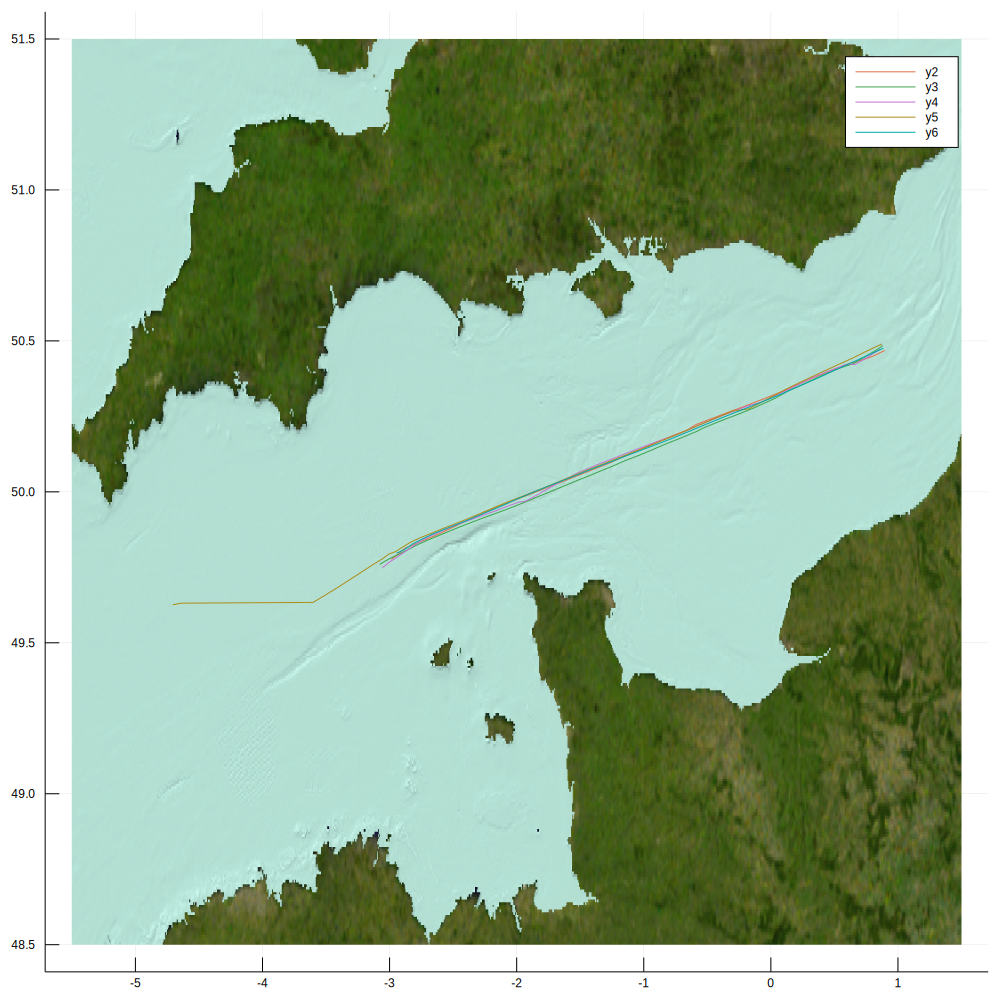

In [6]:
width=1000
height=1000
Plots.default(:size,[width,height])
gebco_server=WmsServer("gebco") #gebco or emodnet-bathymetry or open-streetmap
bbox=[-5.5,48.5,1.5,51.5] #area to plot min(Lon), min(Lat), max(Lon), max(Lat)

img=get_map(gebco_server,bbox,width,height)

plot_image(img,bbox)

plot!(t[1].Lon,t[1].Lat)
plot!(t[2].Lon,t[2].Lat)
plot!(t[3].Lon,t[3].Lat)
plot!(t[4].Lon,t[4].Lat)
plot!(t[5].Lon,t[5].Lat)

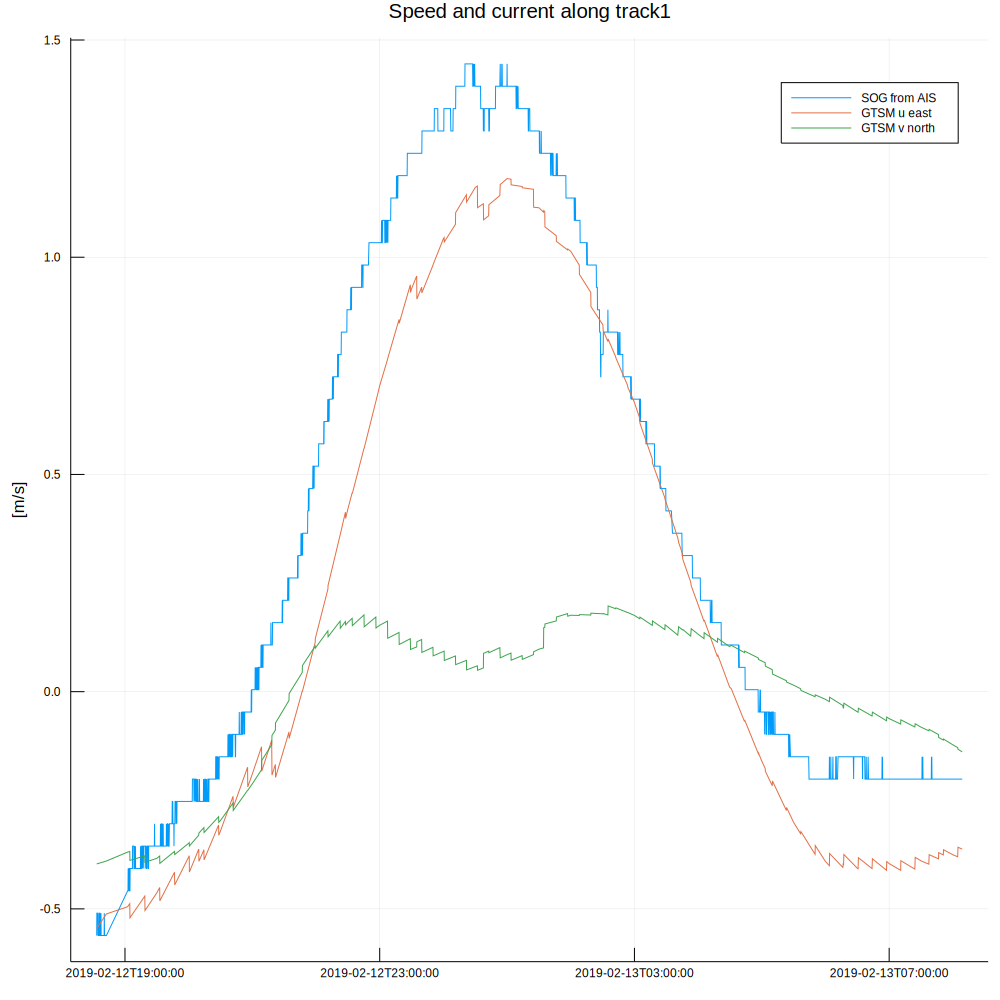

In [10]:
#
# plot speed as timeseries (SOG= Speed Over Ground)
#
knots2ms=0.514444 #conversion of speed as knots to meters/second
#plot(t[1].Times,t[1].SOG*knots2ms)
plot(t[1].Times,[t[1].SOG*knots2ms.-5.5,utrack1,vtrack1],label=["SOG from AIS","GTSM u east","GTSM v north"])
title!("Speed and current along track1")
ylabel!("[m/s]")
